### Some important points

- Exotic event waveforms (Thunder, Surface, Sonic Boom, Plane Crash) are of total of 180s in duration, the actual event start at 70s. 
- Earthquakes, Explosions and Noise are of total of 150s in duration, the actual event start at 50s (Earthquakes and Explosions). 

**Tasks**
1) Experiment with different initial times (0, 20, 50, 60) and compare the obtained duration in each case by making 4 subplots side by side. 
2) Repeat this for different kind of events. 


In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import h5py
import obspy
from obspy.signal.filter import envelope
from obspy.clients.fdsn import Client
from glob import glob #is a function that’s used to search for files that match a specific file pattern or name.
import random

from scipy import signal

In [2]:
def extract_waveforms(cat, file_name):
    
    st = []
    cat_trace = cat['trace_name'].values
    for i in range(len(cat_trace)):

            
 
        f = h5py.File(file_name, 'r')
            
            
        bucket = cat['trace_name'].values[i].split('$')[0]
        ind = int(cat['trace_name'].values[i].split('$')[1].split(',')[0])
        # ENZ
        st.append(f['/data/'+bucket][ind, :3, :18000])
        
    return st


def convert_into_traces(stream, cat):
    channels = ['BHE','BHN','BHZ']
    
    st = []
    for i in range(len(stream)):
        for j in range(len(stream[i])):
            tr = obspy.Trace(stream[i][j])
            tr.stats.channel = channels[j]
            tr.stats.station = cat['station_code'].values[i]
            tr.stats.network = cat['station_network_code'].values[i]
            tr.stats.sampling_rate = 100
            tr.stats.starttime = obspy.UTCDateTime(cat['trace_start_time'].values[i])
            
            st.append(tr)
            
    return obspy.Stream(st)


def plot_waveforms_energy(trace, threshold_low=0.05, threshold_high=0.95, title = 'Thunder Waveforms', xlim = [0, 100], init_time = [0, 20, 50, 60], final_time = 150):
    
    fig, axs = plt.subplots(2, len(init_time), figsize = (5*len(init_time), 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
    
    for j in range(len(init_time)):
        
            #fig, axs = plt.subplots(2, 1, figsize = (12, 12))
        
            sampling_rate = 100
            d = trace.data[init_time[j]*sampling_rate:final_time*sampling_rate]
            t = trace.times()[init_time[j]*sampling_rate:final_time*sampling_rate]
            a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
            lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
            upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
            dur = t[upper_index] - t[lower_index]
             
            ## plotting the seismogram
            axs[0,j].plot(t, d)
            axs[0,j].set_ylabel('Amplitude')
            axs[0,j].set_title(trace.id)
            axs[0,j].set_xlim(init_time[j], xlim[1])
            axs[0,j].axvline(t[lower_index], ls = '--')
            axs[0,j].axvline(t[upper_index], ls = '--')
            axs[0,j].set_title('Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time:"+str(init_time[j])+'s')
            
            # plotting the energy curve
            axs[1,j].plot(t, a)
            axs[1,j].set_xlabel('Time')
            axs[1,j].set_ylabel('Energy')
            axs[1,j].set_xlim(init_time[j], xlim[1])
            axs[1,j].axvline(t[lower_index], ls = '--')
            axs[1,j].axvline(t[upper_index], ls = '--')
    
        
    fig.suptitle(str(trace.stats.starttime)+' '+trace.id, fontsize = 20)
    fig.tight_layout()
        
    # Show the plot
    plt.show()

In [3]:
# collecting waveform data and corresponding catalog.
exotic_file_name = "/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5"
exotic_csv_file = "/data/whd01/yiyu_data/PNWML/exotic_metadata.csv"

comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
comcat_csv_file = "/data/whd01/yiyu_data/PNWML/comcat_metadata.csv"

In [4]:
## collecting the catalog and storing it. 
cat_exotic = pd.read_csv(exotic_csv_file)
cat_comcat = pd.read_csv(comcat_csv_file)

In [5]:
## making SNR in correct format
snrs_exotic = []
for i in range(len(cat_exotic['trace_snr_db'])):
    snrs_exotic.append(np.array(cat_exotic['trace_snr_db'].values[i].split('|')).astype('float')[-1])
    
snrs_comcat = []
for i in range(len(cat_comcat['trace_snr_db'])):
    snrs_comcat.append(np.array(cat_comcat['trace_snr_db'].values[i].split('|')).astype('float')[-1])

In [6]:
cat_exotic['snr_final'] = snrs_exotic
cat_comcat['snr_final'] = snrs_comcat

In [7]:
cat_thunder = cat_exotic[cat_exotic['source_type'] == 'thunder']
cat_surface = cat_exotic[cat_exotic['source_type'] == 'surface event']
cat_sonic = cat_exotic[cat_exotic['source_type'] == 'sonic boom']
cat_plane = cat_exotic[cat_exotic['source_type'] == 'plane crash']

cat_explosion = cat_comcat[cat_comcat['source_type'] == 'explosion']
cat_earthquake = cat_comcat[cat_comcat['source_type'] == 'earthquake']

In [8]:
cat_thunder_good = cat_thunder.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_surface_good = cat_surface.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_sonic_good = cat_sonic.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_plane_good = cat_plane.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_explosion_good = cat_explosion.sort_values(by = 'snr_final', ascending = False).iloc[0:5]
cat_earthquake_good = cat_earthquake.sort_values(by = 'snr_final', ascending = False).iloc[0:5]

In [9]:
stream_exotic = extract_waveforms(cat_thunder_good, exotic_file_name)
tr_thunder_Z = convert_into_traces(stream_exotic, cat_thunder_good).select(channel = '*HZ')

stream_earthquake = extract_waveforms(cat_earthquake_good, comcat_file_name)
tr_earthquake_Z = convert_into_traces(stream_earthquake, cat_earthquake_good).select(channel = '*HZ')


stream_surface = extract_waveforms(cat_surface_good, exotic_file_name)
tr_surface_Z = convert_into_traces(stream_surface, cat_surface_good).select(channel = '*HZ')


stream_explosion = extract_waveforms(cat_explosion_good, comcat_file_name)
tr_explosion_Z = convert_into_traces(stream_explosion, cat_explosion_good).select(channel = '*HZ')

stream_sonic = extract_waveforms(cat_sonic_good, exotic_file_name)
tr_sonic_Z = convert_into_traces(stream_sonic, cat_sonic_good).select(channel = '*HZ')

In [10]:
tr_thunder_Z[0].stats.starttime

2020-08-06T04:36:48.000000Z

## Tasks

- Combine the subplots on the x axis. 
- On the title of the first row - mention - duration, initial time
- On the title of the figure mention - Starttime of the event, and station ID. 


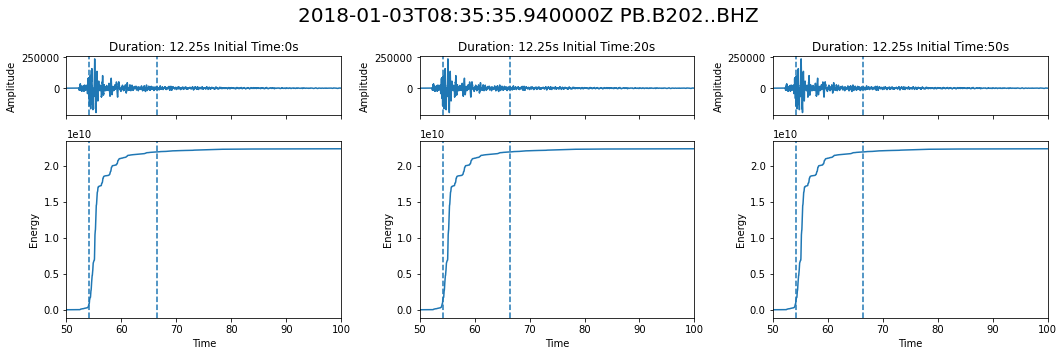

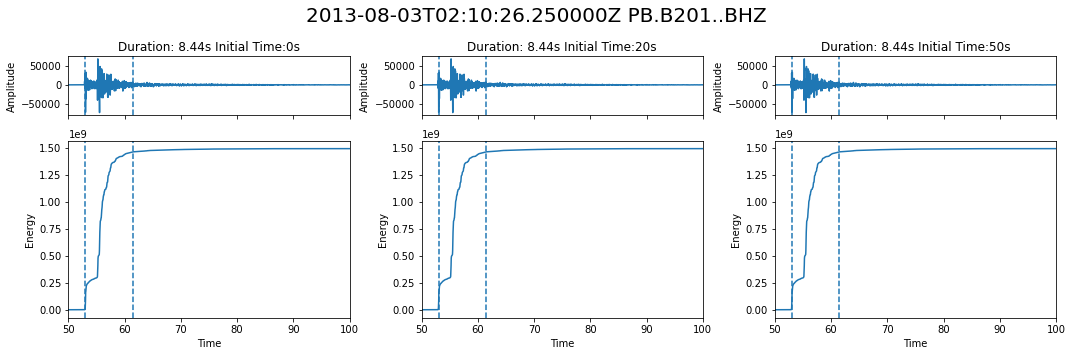

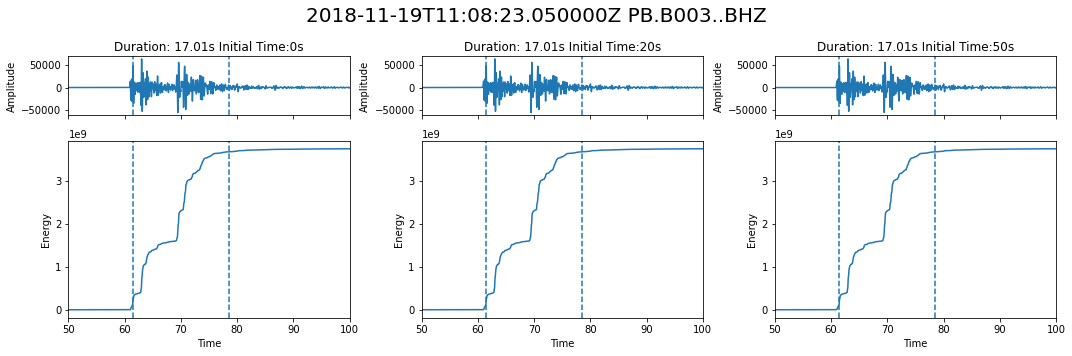

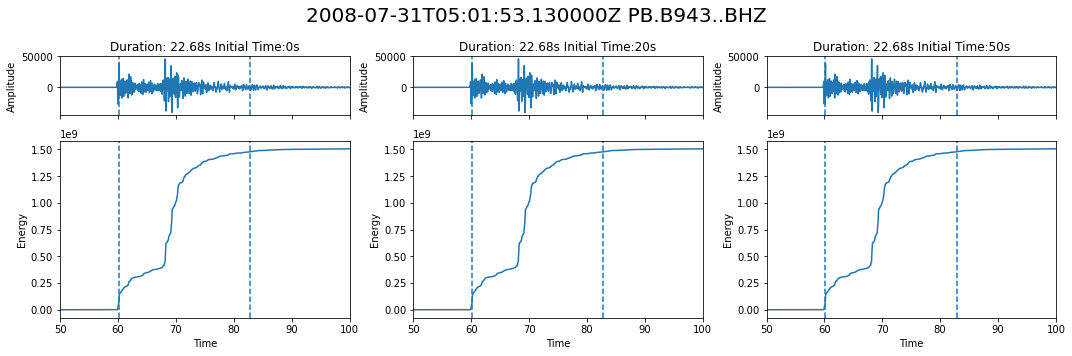

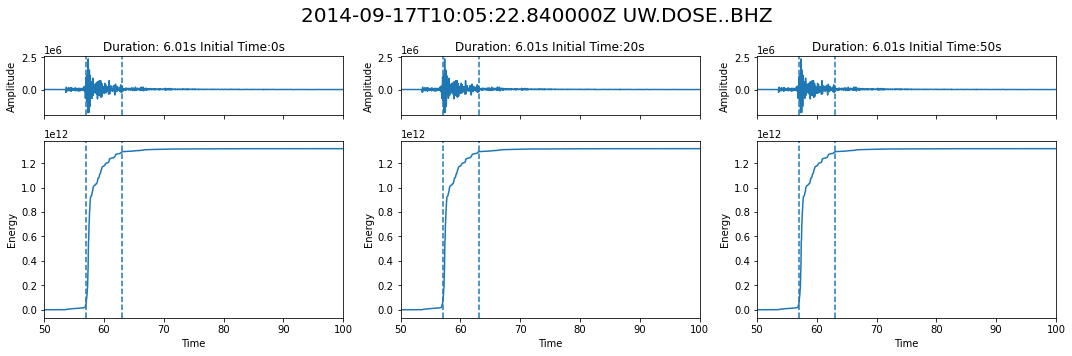

In [11]:
for tr in tr_earthquake_Z:
    plot_waveforms_energy(tr, threshold_low=0.05, threshold_high=0.98, title = 'Earthquake Waveforms', xlim = [0, 100], init_time = [0, 20, 50], final_time = 150)

## Results 

- In case of high SNR earthquakes, it does not matter what is the initial point, we get same duration in all the cases. 
- The upper threshold can be increased to 99.5% as thats what appear to capture the maximum event waveform. 

In [12]:
## Task 

stream_exotic

[array([[ -548.42170411,  -317.43219471,  -221.92250365, ...,
         -1623.64258145, -1595.32619475, -1475.39529843],
        [ 1933.05822706,  2092.75504798,  2153.54961527, ...,
          1235.63798493,  1225.19508843,  1283.54836934],
        [-2337.25011165, -2321.41604802, -2308.2488137 , ...,
         -2352.52046078, -2365.00545705, -2371.56170917]]),
 array([[  9.75072601,  10.75044253,   8.00011294, ...,   0.75002727,
          -1.75021262,  -3.2506728 ],
        [119.74981953, 121.25001946, 122.75031474, ..., 128.75031036,
         124.74999862, 121.99994094],
        [126.75054395, 125.75050915, 118.99957822, ..., 128.50049181,
         126.75032883, 122.24968848]]),
 array([[ 249.50012676,  205.61517418,  171.73462168, ...,  271.17719222,
          292.00067332,  309.63452593],
        [-742.99590817, -742.20906719, -746.24825664, ..., -769.40922039,
         -761.7466941 , -758.78237737],
        [2549.00745233, 2559.73014089, 2557.50672409, ..., 2499.23484656,
         2

In [13]:
stream_exotic = extract_waveforms(cat_thunder_good, exotic_file_name)
tr_thunder = convert_into_traces(stream_exotic, cat_thunder_good)

In [14]:
tr_thunder

15 Trace(s) in Stream:
CC.KWBU..BHE | 2020-08-06T04:36:48.000000Z - 2020-08-06T04:39:47.990000Z | 100.0 Hz, 18000 samples
CC.KWBU..BHN | 2020-08-06T04:36:48.000000Z - 2020-08-06T04:39:47.990000Z | 100.0 Hz, 18000 samples
CC.KWBU..BHZ | 2020-08-06T04:36:48.000000Z - 2020-08-06T04:39:47.990000Z | 100.0 Hz, 18000 samples
CC.KWBU..BHE | 2015-07-10T22:37:25.000000Z - 2015-07-10T22:40:24.990000Z | 100.0 Hz, 18000 samples
CC.KWBU..BHN | 2015-07-10T22:37:25.000000Z - 2015-07-10T22:40:24.990000Z | 100.0 Hz, 18000 samples
CC.KWBU..BHZ | 2015-07-10T22:37:25.000000Z - 2015-07-10T22:40:24.990000Z | 100.0 Hz, 18000 samples
CC.CPCO..BHE | 2019-05-30T18:31:39.000000Z - 2019-05-30T18:34:38.990000Z | 100.0 Hz, 18000 samples
CC.CPCO..BHN | 2019-05-30T18:31:39.000000Z - 2019-05-30T18:34:38.990000Z | 100.0 Hz, 18000 samples
CC.CPCO..BHZ | 2019-05-30T18:31:39.000000Z - 2019-05-30T18:34:38.990000Z | 100.0 Hz, 18000 samples
CC.CPCO..BHE | 2015-06-04T17:37:38.000000Z - 2015-06-04T17:40:37.990000Z | 100.0 Hz, 1

## Tasks 

- Do the same thing as above but for three channels side by side with the initial time of 0 and compare the duration if it depends on the channel or not. 

In [62]:
def extract_waveforms(cat, file_name):
    
    st = []
    cat_trace = cat['trace_name'].values
    for i in range(len(cat_trace)):

            
 
        f = h5py.File(file_name, 'r')
            
            
        bucket = cat['trace_name'].values[i].split('$')[0]
        ind = int(cat['trace_name'].values[i].split('$')[1].split(',')[0])
        # ENZ
        st.append(f['/data/'+bucket][ind, :3, :18000])
        
    return st


def convert_into_traces(stream, cat):
    channels = ['BHE','BHN','BHZ']
    
    st = []
    for i in range(len(stream)):
        for j in range(len(stream[i])):
            tr = obspy.Trace(stream[i][j])
            tr.stats.channel = channels[j]
            tr.stats.station = cat['station_code'].values[i]
            tr.stats.network = cat['station_network_code'].values[i]
            tr.stats.sampling_rate = 100
            tr.stats.starttime = obspy.UTCDateTime(cat['trace_start_time'].values[i])
            
            st.append(tr)
            
    return obspy.Stream(st)


def plot_waveforms_energy(trace, threshold_low=0.05, threshold_high=0.95, xlim = [0, 100], init_time = 0, final_time = 150):
    
    fig, axs = plt.subplots(2, len(trace), figsize = (5*len(trace), 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)
    
    for j in range(len(trace)):
        
            #fig, axs = plt.subplots(2, 1, figsize = (12, 12))
        
            sampling_rate = 100
            d = trace[j].data[init_time*sampling_rate:final_time*sampling_rate]
            t = trace[j].times()[init_time*sampling_rate:final_time*sampling_rate]
            a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
            lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
            upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
            dur = t[upper_index] - t[lower_index]
             
            ## plotting the seismogram
            axs[0,j].plot(t, d)
            axs[0,j].set_ylabel('Amplitude')
            axs[0,j].set_xlim(xlim[0], xlim[1])
            axs[0,j].axvline(t[lower_index], ls = '--', color ='red')
            axs[0,j].axvline(t[upper_index], ls = '--', color ='red')
            axs[0,j].set_title(trace[j].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")
            
            # plotting the energy curve
            axs[1,j].plot(t, a)
            axs[1,j].set_xlabel('Time')
            axs[1,j].set_ylabel('Energy')
            axs[1,j].set_xlim(xlim[0], xlim[1])
            axs[1,j].axvline(t[lower_index], ls = '--', color ='red')
            axs[1,j].axvline(t[upper_index], ls = '--', color ='red')
    
        
    fig.suptitle(str(trace[0].stats.starttime)+' '+trace[0].id, fontsize = 20)
    fig.tight_layout()
        
    # Show the plot
    plt.show()

In [31]:
comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
comcat_csv_file = "/data/whd01/yiyu_data/PNWML/comcat_metadata.csv"

In [42]:
cat_comcat = pd.read_csv(comcat_csv_file)

In [32]:
snrs_comcat = []
for i in range(len(cat_comcat['trace_snr_db'])):
    snrs_comcat.append(np.array(cat_comcat['trace_snr_db'].values[i].split('|')).astype('float')[-1])

In [33]:
cat_comcat['snr_final'] = snrs_comcat

In [34]:
cat_earthquake = cat_comcat[cat_comcat['source_type'] == 'earthquake']

In [35]:
cat_earthquake_good = cat_earthquake.sort_values(by = 'snr_final', ascending = False).iloc[0:5]

In [43]:
stream_earthquake = extract_waveforms(cat_earthquake_good, comcat_file_name)
tr_earthquake_Z= convert_into_traces(stream_earthquake, cat_earthquake_good).select(channel = '*HZ')

In [44]:
B202 = tr_earthquake[0:3]
B201 = tr_earthquake[3:6]
B003 = tr_earthquake[6:9]
B943 = tr_earthquake[9:12]
UW_DOSE =tr_earthquake[12:15]

In [65]:
B202[0].stats

         network: PB
         station: B202
        location: 
         channel: BHE
       starttime: 2018-01-03T08:35:35.940000Z
         endtime: 2018-01-03T08:38:05.940000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 15001
           calib: 1.0

In [47]:
B201

3 Trace(s) in Stream:
PB.B201..BHE | 2013-08-03T02:10:26.250000Z - 2013-08-03T02:12:56.250000Z | 100.0 Hz, 15001 samples
PB.B201..BHN | 2013-08-03T02:10:26.250000Z - 2013-08-03T02:12:56.250000Z | 100.0 Hz, 15001 samples
PB.B201..BHZ | 2013-08-03T02:10:26.250000Z - 2013-08-03T02:12:56.250000Z | 100.0 Hz, 15001 samples

In [46]:
B202 

3 Trace(s) in Stream:
PB.B202..BHE | 2018-01-03T08:35:35.940000Z - 2018-01-03T08:38:05.940000Z | 100.0 Hz, 15001 samples
PB.B202..BHN | 2018-01-03T08:35:35.940000Z - 2018-01-03T08:38:05.940000Z | 100.0 Hz, 15001 samples
PB.B202..BHZ | 2018-01-03T08:35:35.940000Z - 2018-01-03T08:38:05.940000Z | 100.0 Hz, 15001 samples

In [48]:
B003

3 Trace(s) in Stream:
PB.B003..BHE | 2018-11-19T11:08:23.050000Z - 2018-11-19T11:10:53.050000Z | 100.0 Hz, 15001 samples
PB.B003..BHN | 2018-11-19T11:08:23.050000Z - 2018-11-19T11:10:53.050000Z | 100.0 Hz, 15001 samples
PB.B003..BHZ | 2018-11-19T11:08:23.050000Z - 2018-11-19T11:10:53.050000Z | 100.0 Hz, 15001 samples

In [49]:
B943

3 Trace(s) in Stream:
PB.B943..BHE | 2008-07-31T05:01:53.130000Z - 2008-07-31T05:04:23.130000Z | 100.0 Hz, 15001 samples
PB.B943..BHN | 2008-07-31T05:01:53.130000Z - 2008-07-31T05:04:23.130000Z | 100.0 Hz, 15001 samples
PB.B943..BHZ | 2008-07-31T05:01:53.130000Z - 2008-07-31T05:04:23.130000Z | 100.0 Hz, 15001 samples

In [50]:
UW_DOSE

3 Trace(s) in Stream:
UW.DOSE..BHE | 2014-09-17T10:05:22.840000Z - 2014-09-17T10:07:52.840000Z | 100.0 Hz, 15001 samples
UW.DOSE..BHN | 2014-09-17T10:05:22.840000Z - 2014-09-17T10:07:52.840000Z | 100.0 Hz, 15001 samples
UW.DOSE..BHZ | 2014-09-17T10:05:22.840000Z - 2014-09-17T10:07:52.840000Z | 100.0 Hz, 15001 samples

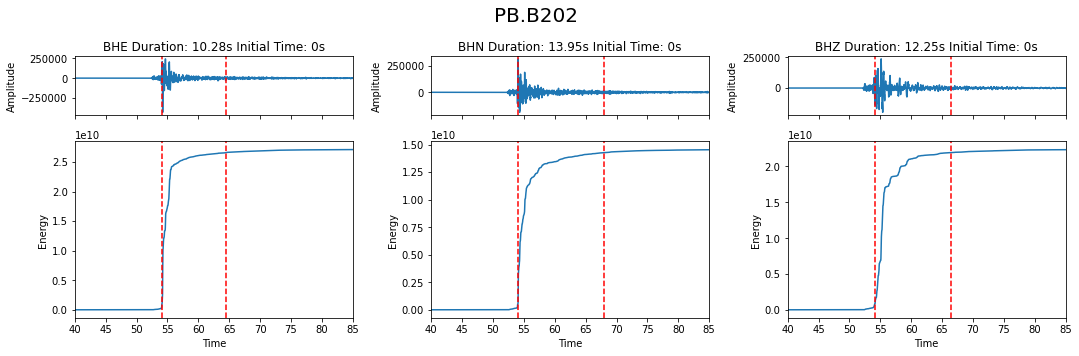

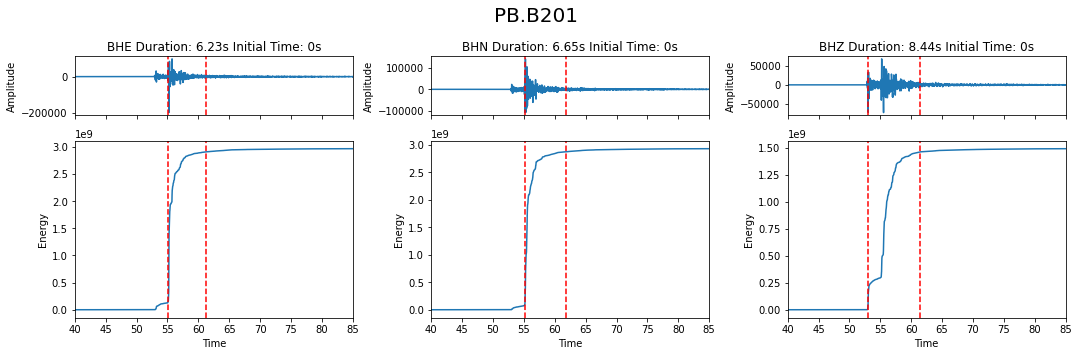

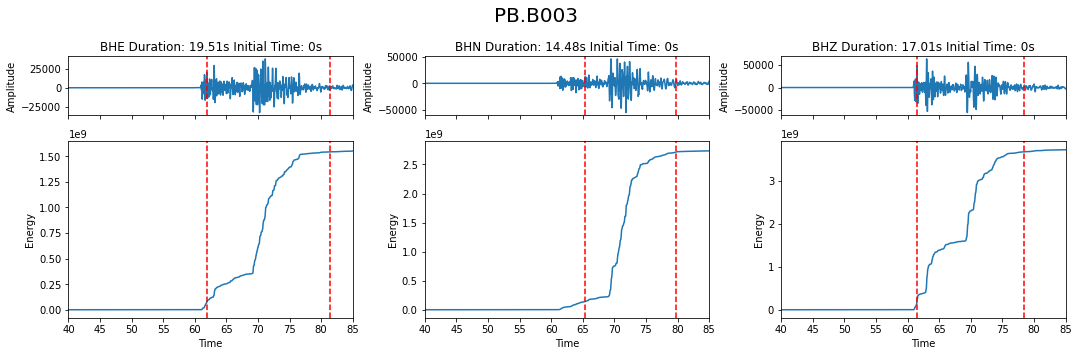

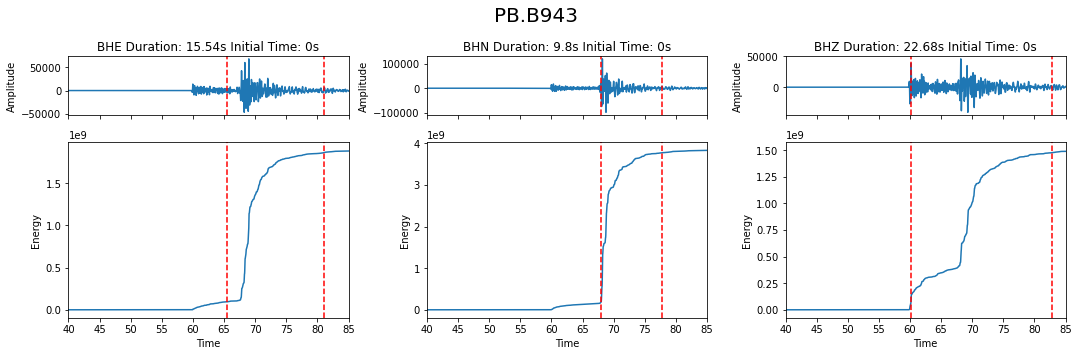

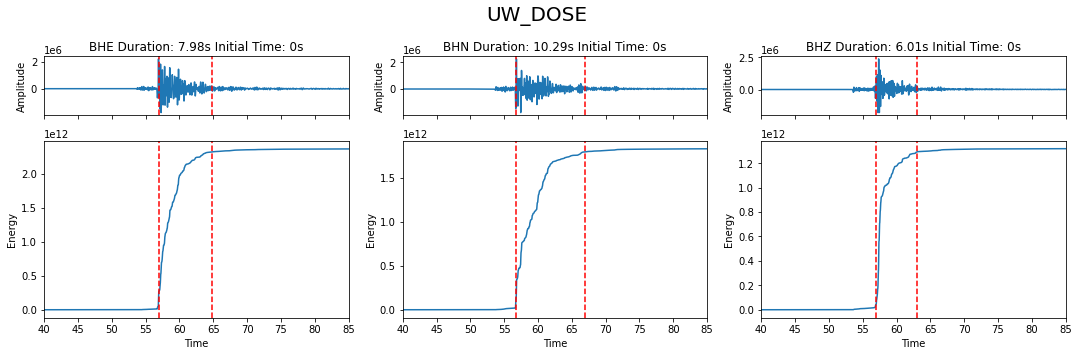

In [57]:
plot_waveforms_energy(B202, threshold_low=0.05, threshold_high=0.98, title='PB.B202', xlim = [40, 85], init_time = 0, final_time = 150)
plot_waveforms_energy(B201, threshold_low=0.05, threshold_high=0.98, title='PB.B201', xlim = [40, 85], init_time = 0, final_time = 150)
plot_waveforms_energy(B003, threshold_low=0.05, threshold_high=0.98, title='PB.B003', xlim = [40, 85], init_time = 0, final_time = 150)
plot_waveforms_energy(B943, threshold_low=0.05, threshold_high=0.98, title='PB.B943', xlim = [40, 85], init_time = 0, final_time = 150)
plot_waveforms_energy(UW_DOSE, threshold_low=0.05, threshold_high=0.98, title='UW_DOSE', xlim = [40, 85], init_time = 0, final_time = 150)

## Tasks

- Make the vertical lines in red color. 
- Zoom in the plots between 40 - 80s
- Put the results on slack - asking which component to use. 
- Show the wrong case, where the vertical line is later


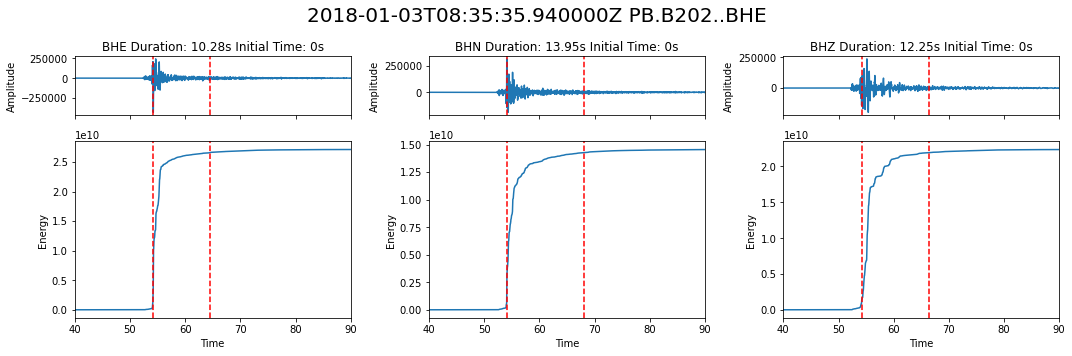

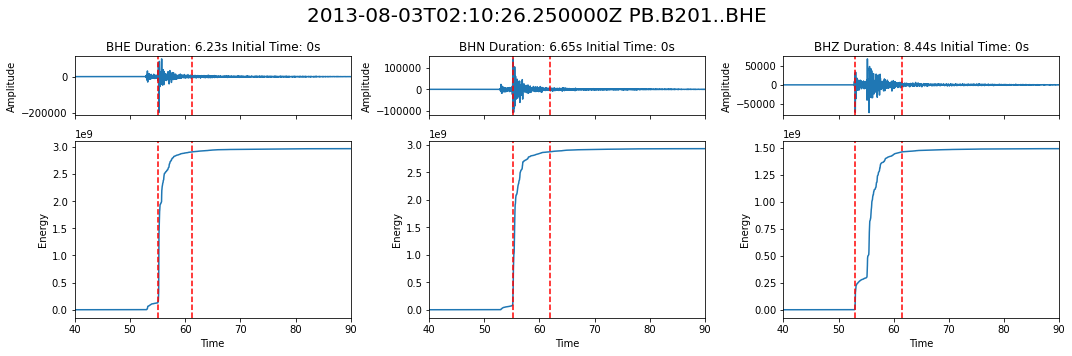

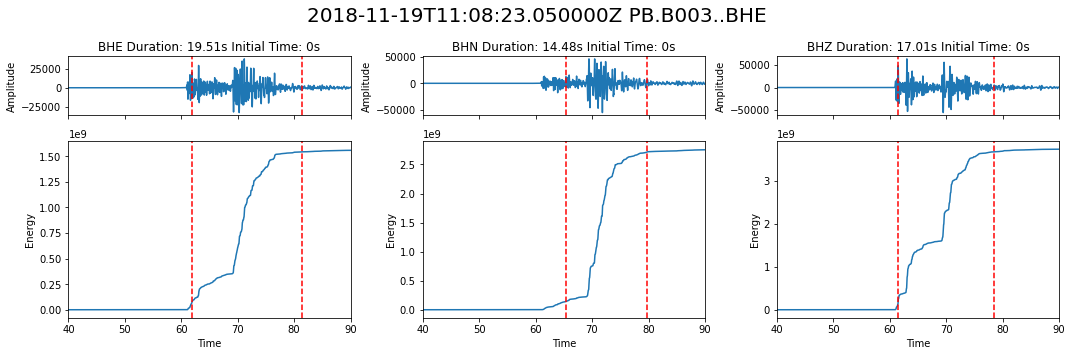

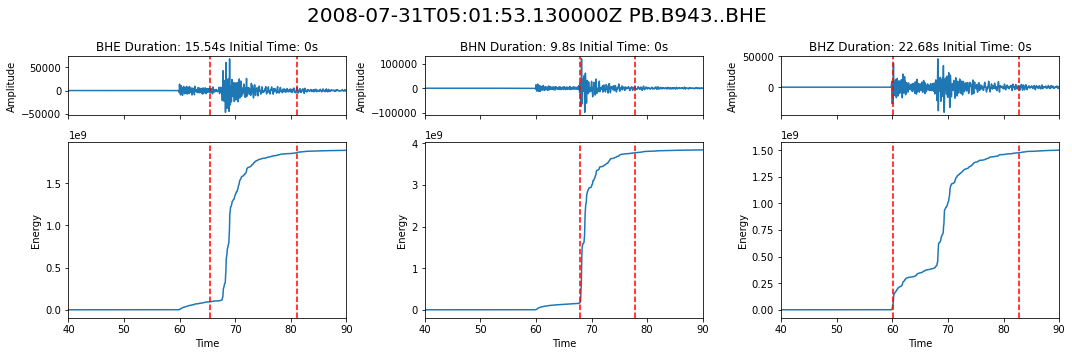

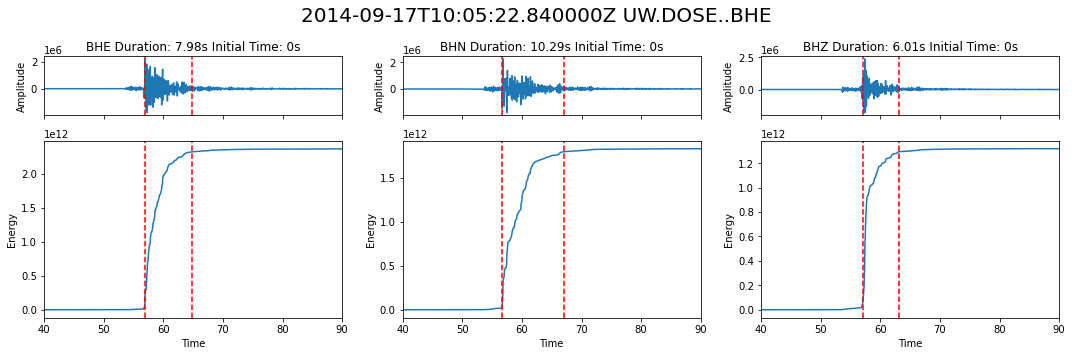

In [64]:
plot_waveforms_energy(B202, threshold_low=0.05, threshold_high=0.98, xlim = [40, 90], init_time = 0, final_time = 150)
plot_waveforms_energy(B201, threshold_low=0.05, threshold_high=0.98, xlim = [40, 90], init_time = 0, final_time = 150)
plot_waveforms_energy(B003, threshold_low=0.05, threshold_high=0.98, xlim = [40, 90], init_time = 0, final_time = 150)
plot_waveforms_energy(B943, threshold_low=0.05, threshold_high=0.98, xlim = [40, 90], init_time = 0, final_time = 150)
plot_waveforms_energy(UW_DOSE, threshold_low=0.05, threshold_high=0.98, xlim = [40, 90], init_time = 0, final_time = 150)